# Active Learning on MNIST

This notebook demonstrates how to apply a variety of acquisition functions for doing active learning with a more complex model - i.e. a neural network. Both classic acquisition functions as well as a prediction-oriented one are considered. These are:
- Random
- Minimum Margin Sampling
- Variation Ratios
- Entropy
- Bayesian Active Learning by Disagreement - BALD
- Expected Predictive Information Gain - EPIG

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Load MNIST data

In [10]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### Visualize data

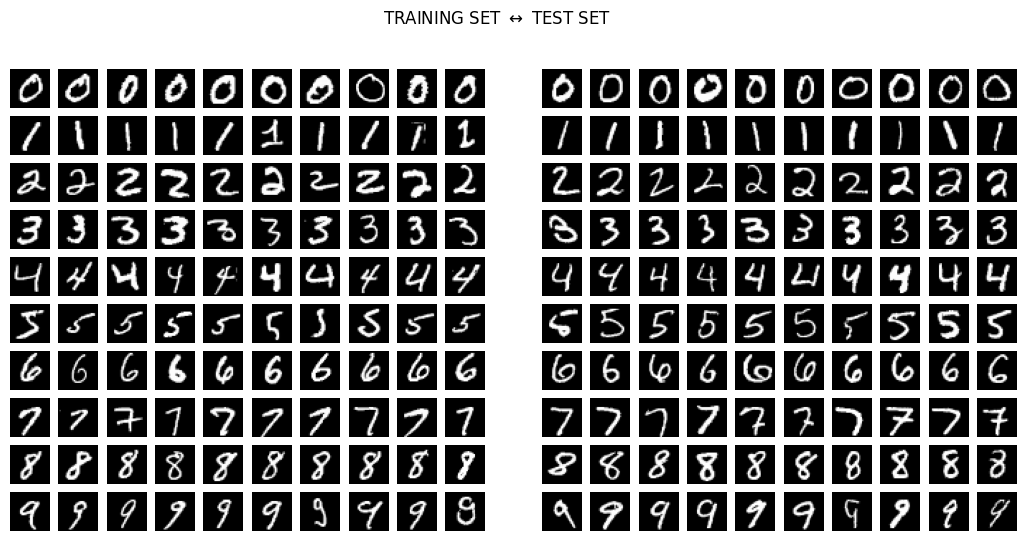

In [4]:
fig, axs = plt.subplots(10, 21, figsize=(13, 6))
for i in range(len(trainloader.dataset.classes)):
    imgs = trainloader.dataset.data[trainloader.dataset.targets == i][:10]
    for j in range(10):
        axs[i, j].imshow(imgs[j], cmap='gray')
        axs[i, j].axis('off') 

    axs[i, 10].axis('off')

for i in range(len(testloader.dataset.classes)):
    imgs = testloader.dataset.data[testloader.dataset.targets == i][:10]
    for j in range(10):
        axs[i, 11+j].imshow(imgs[j], cmap='gray')
        axs[i, 11+j].axis('off') 
fig.suptitle('TRAINING SET $\leftrightarrow$ TEST SET')
plt.show()

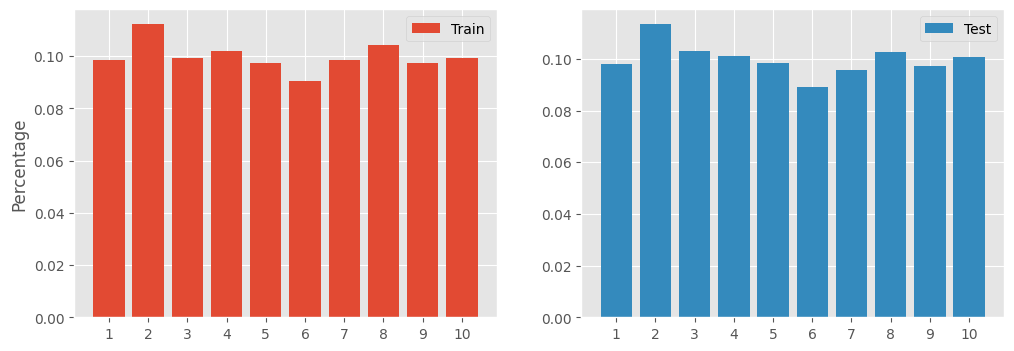

In [5]:
train_dist  = Counter(trainloader.dataset.targets.numpy())
test_dist   = Counter(testloader.dataset.targets.numpy())

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
ax.bar(train_dist.keys(), np.array(list(train_dist.values())) / sum(list(train_dist.values())), color='C0', label='Train')
ax.set_ylabel('Percentage')
ax.set_xticks(list(train_dist.keys()), 1 + np.array(list(train_dist.keys())))
ax.legend()

ax = fig.add_subplot(122)
ax.bar(test_dist.keys(), np.array(list(test_dist.values())) / sum(list(test_dist.values())), color='C1', label='Test')
ax.set_xticks(list(test_dist.keys()), 1 + np.array(list(test_dist.keys())))
ax.legend()

plt.show()

### Train model

In [18]:
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

from torch.nn.functional import log_softmax, nll_loss

In [117]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1  = nn.Conv2d(1, 32, 5)
        self.pool   = nn.MaxPool2d(2, 2)
        self.conv2  = nn.Conv2d(32, 64, 5)
        self.fc1    = nn.Linear(64 * 4 * 4, 120)
        self.fc2    = nn.Linear(120, 84)
        self.fc3    = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [119]:
model_type = 'LeNet'

# Setup model
if model_type == 'ResNet':
    model       = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    model.fc    = nn.Linear(model.fc.in_features, 10)
else:
    model = LeNet()

# Set device for model
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define parameters
lr          = 0.01
epochs      = 5
val_step    = 1
optimizer   = optim.Adam(model.parameters(), lr=1e-4)
seed        = 0

In [73]:
np.random.seed(seed)
torch.manual_seed(seed)

accs    = {'train': {}, 'validation': {}}
losses  = {'train': {}, 'validation': {}}
current_best_loss = np.inf

for epoch in range(epochs):
    model.train()

    train_acc, train_loss = 0, 0
    for batch_idx, batch in enumerate(tqdm(trainloader)):
        # Map data to GPU
        imgs, labels    = batch[0].to(device), batch[1].to(device)

        # Set grad zero
        optimizer.zero_grad()

        # Get predictions
        outputs         = model(imgs)
        log_probs       = log_softmax(outputs, dim=1)

        # Compute loss
        loss    = nll_loss(log_probs, labels)
        loss.backward()
        # Optimize
        optimizer.step()

        # Compute accuracy for batch
        _, pred_class   = torch.topk(outputs, k=1)
        train_acc       += torch.mean((pred_class.flatten() == labels).float()).cpu()
        train_loss      += loss.item()

    # Store information
    accs['train'][epoch]    = train_acc / len(trainloader)
    losses['train'][epoch]  = train_loss / len(trainloader)

    if epoch % val_step == 0:
        model.eval()
        with torch.no_grad():
            val_acc, val_loss = 0, 0
            for batch_idx, batch in enumerate(tqdm(testloader)):
                # Map data to GPU
                imgs, labels    = batch[0].to(device), batch[1].to(device)
                # Get predictions
                outputs         = model(imgs)
                log_probs       = log_softmax(outputs, dim=1)
                
                # Compute loss
                loss    = nll_loss(log_probs, labels)

                # Compute accuracy for batch
                _, pred_class   = torch.topk(outputs, k=1)
                val_acc        += torch.mean((pred_class.flatten() == labels).float()).cpu()
                val_loss      += loss.item()

            accs['validation'][epoch]   = val_acc / len(testloader)
            losses['validation'][epoch] = val_loss / len(testloader)

        if losses['validation'][epoch] < current_best_loss:
            current_best_loss = losses['validation'][epoch]
            torch.save(model.state_dict(), f'../models/MNIST/{model.__class__.__name__}_best.pth')
            print("Saved new model!")

    print(f"EPOCH {epoch+1}/{epochs}: Train acc. = {accs['train'][epoch]:.4f} \t | Validation acc. = {accs['validation'][epoch]:.4f} \t | Train loss = {losses['train'][epoch]:.4f} \t | Validation loss = {losses['validation'][epoch]:.4f}")

100%|██████████| 79/79 [00:05<00:00, 15.41it/s]


Saved new model!
EPOCH 1/5: Train acc. = 0.9092 	 | Validation acc. = 0.9717 	 | Train loss = 0.2912 	 | Validation loss = 0.0913


100%|██████████| 79/79 [00:04<00:00, 19.27it/s]


Saved new model!
EPOCH 2/5: Train acc. = 0.9783 	 | Validation acc. = 0.9802 	 | Train loss = 0.0710 	 | Validation loss = 0.0650


100%|██████████| 79/79 [00:04<00:00, 18.64it/s]


Saved new model!
EPOCH 3/5: Train acc. = 0.9860 	 | Validation acc. = 0.9864 	 | Train loss = 0.0452 	 | Validation loss = 0.0482


100%|██████████| 79/79 [00:04<00:00, 18.41it/s]


EPOCH 4/5: Train acc. = 0.9893 	 | Validation acc. = 0.9851 	 | Train loss = 0.0335 	 | Validation loss = 0.0493


100%|██████████| 79/79 [00:04<00:00, 18.81it/s]

Saved new model!
EPOCH 5/5: Train acc. = 0.9920 	 | Validation acc. = 0.9873 	 | Train loss = 0.0252 	 | Validation loss = 0.0405


### Load pre-trained model

In [125]:
model_type = 'ResNet'

In [126]:
if model_type == 'ResNet':
    model       = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    model.fc    = nn.Linear(model.fc.in_features, 10)

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

else:
    model = LeNet()
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

model.load_state_dict(torch.load(f'../models/MNIST/{model_type}_best.pth'))
print("Loaded pretrained model")

Loaded pretrained model


In [127]:
predictions, gt_labels = [], []

for (imgs, labels) in tqdm(testloader):
    imgs, labels    = imgs.to(device), labels.to(device)

    outputs         = model(imgs)
    _, pred_class   = outputs.topk(1)

    predictions.append(pred_class.flatten())
    gt_labels.append(labels.flatten())

100%|██████████| 79/79 [00:04<00:00, 18.14it/s]


In [128]:
# Mispredictions
Counter(torch.hstack(gt_labels).cpu().numpy()[(torch.hstack(predictions).cpu().numpy() != torch.hstack(gt_labels).cpu().numpy())])

Counter({9: 31, 7: 18, 8: 18, 4: 16, 2: 13, 3: 13, 5: 13, 0: 12, 6: 9, 1: 8})